<a href="https://colab.research.google.com/github/Sziroky/Diet-AI-Agent-App/blob/main/part2_TesseractOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Diet AI Agent - Extraction using PyTesseract

## Install the OCR

In [1]:
#Install and Import The Tesseract
test = !pytesseract

if '/bin/bash: line 1: pytesseract: command not found' in test:
  print('Install PyTesseract')
  !sudo apt-get install tesseract-ocr
  !pip install pytesseract
else:
  print('PyTesseract Installed')

Install PyTesseract
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
import pytesseract

#Test if tesseract has polish Language if not Install it
test = !tesseract --list-langs
if 'pol' in test:
  print("Polish Language Available")
else:
  !sudo apt-get install tesseract-ocr-pol

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-pol
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,610 kB of archives.
After this operation, 4,780 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-pol all 1:4.00~git30-7274cfa-1.1 [1,610 kB]
Fetched 1,610 kB in 0s (5,089 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tesseract-ocr-pol.
(Readin

## Import the data

In [27]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

unprocessed_images = Path('/content/drive/MyDrive/Colab Notebooks/images/')
u_images=list(unprocessed_images.iterdir())

In [22]:
processed_images = Path("/content/drive/MyDrive/RespoRecipes")

p_images = list(processed_images.rglob('*.jpg'))

In [31]:
p_example = cv2.imread(p_images[1])
u_example = cv2.imread(u_images[0])

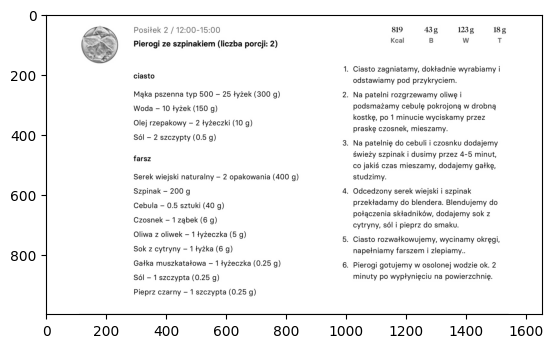

In [32]:
plt.imshow(p_example)

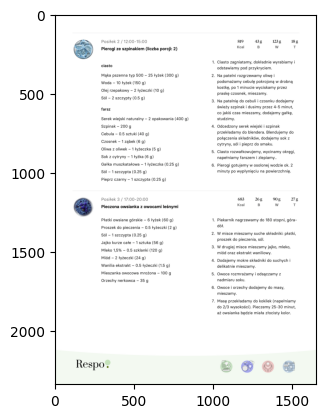

In [33]:
plt.imshow(u_example)

Let's test how Tesseract will handle the whole documents but first a little codelab...

## PyTesseract 101

In [34]:
# Extract the data
data = pytesseract.image_to_data(p_example, output_type=pytesseract.Output.DICT, lang='pol')

In [36]:
# As a result we get the extracted data we can create a  dataframe
import pandas as pd

df = pd.DataFrame(data)

In [38]:
df.head(23)

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,1653,998,-1,
1,2,1,1,0,0,0,115,39,129,128,-1,
2,3,1,1,1,0,0,115,39,129,128,-1,
3,4,1,1,1,1,0,115,39,129,128,-1,
4,5,1,1,1,1,1,115,39,129,128,95,
5,2,1,2,0,0,0,294,43,285,23,-1,
6,3,1,2,1,0,0,294,43,285,23,-1,
7,4,1,2,1,1,0,294,43,285,23,-1,
8,5,1,2,1,1,1,294,43,88,20,95,Posiłek
9,5,1,2,1,1,2,394,43,11,19,93,2


The Dataframe consits of:
- level detection - indicates the region (page, block, paragraph,line, world)
- id of the region - in which region the data was extracted.
- coordinates - bounding box of detection region
- confidence - how the OCR is confident of what it has extracted
- text - the actual text extracted

In [39]:
# LEVEL 1
level = 1
df[df['level']==level]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,1653,998,-1,


In [55]:
def get_bb(df,level):
  x,y = df[df['level']==level]['left'].values[0],df[df['level']==level]['top'].values[0]
  w,h = df[df['level']==level]['width'].values[0], df[df['level']==level]['height'].values[0]
  return x,y,w,h

In [65]:
x,y,w,h = get_bb(df,4)

In [66]:
def draw_bb(img,x,y,w,h,width=10,color=(255,255,0)):
  cv2.rectangle(img,(int(x), int(y)), (int(x) + int(w), int(y) + int(h)), color,width)

In [67]:
draw_bb(p_example,x,y,w,h)

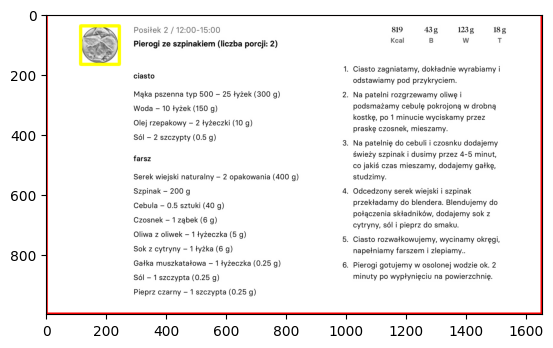

In [68]:
plt.imshow(p_example)